#### Agora vamos implementar nosso modelo!

Primeiramente, vamos extrair o dataset, assim com fizemos no tutorial passado.

In [26]:
import torch
import torchvision
from torchvision import transforms, datasets

train = datasets.MNIST("", train = True, download=True, 
                      transform = transforms.Compose([transforms.ToTensor()]))

test = datasets.MNIST("", train = False, download=True, 
                      transform = transforms.Compose([transforms.ToTensor()]))

trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)

Vamos começar a implementação do modelo. Em pytorch, para criar a rede, nós criamos uma classe. No init dessa classe nós definimos nossas camadas. Depois, definiremos qual será o fluxo que os dados farão através dessas camadas.

In [27]:
import torch.nn as nn
import torch.nn.functional as F

Vamos deixar o bloco abaixo para definir algumas variáveis. Por enquanto, definiremos nele a dimensão das imagens.

In [28]:
#Vamos fazer uma única iteração para pegar um elemento do batch de 10
for data in trainset:
    #O primeiro [0] corresponde ao acesso às imagens de entrada.
    #O segundo [0] é pq estamos pegando a primeira imagem(poderia ser qualquer uma das 10)
    shape = data[0][0].shape
    break
    
#Definindo as variáveis
n_c = shape[0]
n_h = shape[1]
n_w = shape[2]

print("n_c: ", n_c, "| n_h: ", n_h, "| n_w: ", n_w)

n_c:  1 | n_h:  28 | n_w:  28


In [29]:
#Criamos o modelo Net, que sempre deverá herdar da classe nn.Module
class Net(nn.Module):
    
    def __init__(self):
        #O método super serve para herdar o __init__ da classe pai
        super().__init__()
        
    #Definindo as layers
    
        #A primeira layer será uma fully-connected. Para isso, criamos uma variável self.fc1
        #O método nn.Linear() basicamente aplica y = W^t*x + b, ou seja, passa pelo neurônio 
                                                 #mas ainda não utiliza a função de ativação
        #Temos a estrutura torch.nn.Linear(in_features: int, out_features: int, bias: bool = True)
        #Lembre que o input deve ser "flattened" para passar por uma camada fully-connected
        #Faremos 4 hidden layers, todas com 64 neurônios.
        self.fc1 = nn.Linear(n_h*n_w, 64)
        #A segunda hidden layer tem como entrada o output anterior, que tem dimensão 64
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        #Acima, temos 3 hidden layers de 64 neurônios.
        #Abaixo, temos a output layer, com 10 neurônios, um para cada dígito.
        self.fc4 = nn.Linear(64, 10)
        
        
    #Agora, vamos definir como será o fluxo. É valido ressaltar que o backward prop é feito automaticamente. 
    def forward(self, x):
        #Note que o dado passa pela camada e logo depois pela função de ativação
        #Nas hidden layers, utilizaremos relu
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        #Na última camada, não passamos pela função de ativação ainda
        #Passaremos agora. Utilizaremos a softmax pois temos 10 labels.
        
        #O parâmetro dim=1 é algo similar a axis=1. O cara que estava ensinando
        #o tutorial tbm não sabia direito. Usar dim=1 sempre. Quando der merda, vc aprende o que é.
        return F.log_softmax(x, dim=1)

#### Vamos definir nosso modelo 

In [30]:
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


#### Vamos passar alguns dados pela nossa rede só para testar.

In [31]:
#Criando um Tensor de números randômicos de shape [28, 28]
teste = torch.rand((28,28))
                
#Usando reshape. O -1 indica que não sabemos o número de canais. Caso soubéssemos, era só colocar lá.
teste = teste.view(1, 28*28)


In [32]:
output = net(teste)
print(output)

tensor([[-2.4377, -2.1972, -2.2196, -2.4423, -2.2101, -2.3048, -2.1610, -2.3537,
         -2.3575, -2.3908]], grad_fn=<LogSoftmaxBackward>)





## Agora, vamos manipular o Backward Prop. Utilizaremos o Adam Optimizer.

In [33]:
import torch.optim as optim

#Passamos ao optimizer os parâmetros da rede e a learning rate.
optimizer = optim.Adam(net.parameters(), lr=0.001)

#### Epoch: Passar uma vez por todo o conjunto de dados corresponde a uma época.

In [46]:
EPOCHS = 3

#Passando EPOCHS vezes pelo dataset
for epoch in range(EPOCHS):
    #data é um batch de features e labels do trainset
    for data in trainset:
        
        #Separando os dados em features(X) e labels(y)
        X, y = data
        
        #A cada iteração, devemos zerar o gradiente. Caso contrário
        #o somatório da loss não será zerado para um novo cálculo 
        #da cost function
        net.zero_grad()
        
        #Passando os dados pela rede. O view faz um reshape logo antes dos dados entrarem na rede
        output = net(X.view(-1, n_h*n_w))
        print("OUTPUT: ", output)
        #Agora é o momento de calcular a loss
        loss = F.nll_loss(output, y)
        #Fazendo o backprop da loss
        loss.backward()
        
        #Atualizando os pesos após o calculo do backward prop
        optimizer.step()
        
    print("Loss: ", loss)

OUTPUT:  tensor([[-4.7648e+01, -1.8051e+01, -2.1290e+01, -2.0945e+01, -2.3757e+01,
         -3.9067e+01, -8.2175e+01,  0.0000e+00, -3.2990e+01, -1.8235e+01],
        [-3.5403e+01, -2.5610e+01, -2.5475e+01, -2.2268e+01, -3.0677e+01,
         -2.5964e+01, -2.9050e+01, -3.3871e+01,  0.0000e+00, -2.3248e+01],
        [-1.2889e+02, -6.0553e+01, -5.3825e+01,  0.0000e+00, -1.3156e+02,
         -5.5935e+01, -1.6827e+02, -5.2632e+01, -7.1898e+01, -7.3048e+01],
        [-3.9152e+01, -3.3311e+01, -3.6986e+01, -3.6699e+01, -3.5436e+01,
         -3.9704e+01, -3.8576e+01, -4.8020e+01,  0.0000e+00, -3.4084e+01],
        [-2.0543e+01, -9.6559e-06, -1.3147e+01, -2.3280e+01, -1.5523e+01,
         -2.0771e+01, -1.5552e+01, -1.3979e+01, -1.1952e+01, -1.5688e+01],
        [-2.7987e+01, -4.1479e+01, -2.6497e+01, -4.2850e+01, -3.3661e+01,
         -4.5975e+01, -9.6923e+01,  0.0000e+00, -4.7730e+01, -1.6874e+01],
        [-3.0069e+01, -4.3136e+01, -3.5492e+01, -4.0686e+01, -2.7458e+01,
         -1.3516e+01, -

OUTPUT:  tensor([[-4.4647e+01, -3.2601e+01,  0.0000e+00, -1.8382e+01, -3.3057e+01,
         -6.2802e+01, -7.2490e+01, -5.1621e+01, -5.7076e+01, -4.5579e+01],
        [-1.2045e+02, -7.5956e+01, -4.5314e+01,  0.0000e+00, -1.1447e+02,
         -7.2155e+01, -1.5713e+02, -4.8753e+01, -4.1621e+01, -9.0705e+01],
        [-1.1670e+02, -6.0957e+01, -5.3037e+01,  0.0000e+00, -1.1411e+02,
         -4.9526e+01, -1.3369e+02, -4.4864e+01, -5.3645e+01, -6.6501e+01],
        [-3.7616e+01, -6.2838e+01, -3.9374e+01, -2.9687e+01, -3.2270e+01,
         -3.0399e+01, -8.1012e+01, -3.1017e+01, -3.5778e+01,  0.0000e+00],
        [-5.1011e+01, -9.5725e+01, -6.7660e+01, -8.2650e+01, -5.7149e+01,
         -3.4529e+01,  0.0000e+00, -9.0329e+01, -6.0115e+01, -5.7849e+01],
        [-5.8069e+01, -2.1577e-05, -1.2140e+01, -1.8403e+01, -1.4408e+01,
         -1.3910e+01, -1.2349e+01, -1.3884e+01, -1.1607e+01, -1.4975e+01],
        [-2.3249e+01, -5.3132e+01, -2.5129e+01, -2.2302e+01, -2.3246e+01,
         -2.7686e+01, -

OUTPUT:  tensor([[-7.6314e+01, -6.8206e+01, -5.1744e+01, -9.5343e+01,  0.0000e+00,
         -8.7796e+01, -7.3097e+01, -5.5915e+01, -6.2188e+01, -4.2314e+01],
        [-3.1464e+01, -6.0298e+01, -5.1642e+01, -1.6587e+01, -9.1922e+01,
         -1.1921e-07, -2.8542e+01, -4.6763e+01, -2.8277e+01, -2.9983e+01],
        [-1.5493e+01, -2.0517e+01, -1.4414e+01, -2.9127e+00, -4.2596e+00,
         -3.5723e+00, -1.4830e+01, -8.6040e+00, -1.0437e+01, -1.0177e-01],
        [-1.6918e+02,  0.0000e+00, -5.3571e+01, -8.8254e+01, -5.4785e+01,
         -7.3986e+01, -8.0786e+01, -5.2210e+01, -5.6942e+01, -6.3444e+01],
        [-6.3872e+01, -6.7089e+01,  0.0000e+00, -4.2072e+01, -6.6632e+01,
         -1.2391e+02, -7.4240e+01, -7.1001e+01, -7.0483e+01, -1.2216e+02],
        [ 0.0000e+00, -8.3013e+01, -3.2493e+01, -6.9430e+01, -5.8958e+01,
         -6.0500e+01, -6.4625e+01, -2.7982e+01, -6.2660e+01, -4.1382e+01],
        [-8.1613e+01, -1.1038e+02, -8.2561e+01, -9.8643e+01, -6.9881e+01,
         -3.3424e+01,  

OUTPUT:  tensor([[-4.3764e+01, -5.6205e+01,  0.0000e+00, -2.4670e+01, -4.2798e+01,
         -7.1509e+01, -5.0176e+01, -4.2410e+01, -3.6394e+01, -6.9134e+01],
        [ 0.0000e+00, -9.6762e+01, -4.0263e+01, -7.0989e+01, -5.2280e+01,
         -6.6942e+01, -5.1611e+01, -3.6471e+01, -7.4048e+01, -4.1362e+01],
        [-5.8987e+01, -3.8680e+01, -3.7672e+01, -2.9649e+01, -2.9123e+01,
         -3.8264e+01, -4.3419e+01, -3.8774e+01, -3.5763e-07, -1.4735e+01],
        [-8.8708e+01, -1.2072e+02, -8.8870e+01, -1.1643e+02, -6.8618e+01,
         -3.8601e+01,  0.0000e+00, -1.1430e+02, -8.0973e+01, -8.1414e+01],
        [ 0.0000e+00, -8.0090e+01, -3.2509e+01, -6.6568e+01, -6.8909e+01,
         -5.5905e+01, -5.7035e+01, -3.9932e+01, -5.9991e+01, -4.4685e+01],
        [-2.5789e+01, -3.1810e+01, -2.7841e+01, -4.9058e+01, -1.1921e-07,
         -3.8986e+01, -2.8737e+01, -2.0133e+01, -3.6084e+01, -1.6116e+01],
        [-8.6404e+01, -6.1749e+01,  0.0000e+00, -7.0860e+01, -8.2639e+01,
         -1.6635e+02, -

OUTPUT:  tensor([[-1.0988e+02, -3.5334e+01, -3.1068e+01,  0.0000e+00, -7.8635e+01,
         -3.4637e+01, -1.0473e+02, -3.5721e+01, -4.5852e+01, -4.3039e+01],
        [-1.3692e+02, -1.4364e+02, -1.1943e+02, -1.6467e+02, -1.3801e+02,
         -1.4722e+02, -2.4497e+02,  0.0000e+00, -1.8984e+02, -8.2239e+01],
        [-1.2898e+02, -4.8180e+01, -5.0587e+01, -4.5373e+01, -6.0541e+01,
         -8.9648e+01, -2.0460e+02,  0.0000e+00, -9.7352e+01, -3.4558e+01],
        [-5.9438e+01, -9.4040e+01, -7.2481e+01, -8.9653e+01, -5.5471e+01,
         -3.5132e+01,  0.0000e+00, -8.4476e+01, -5.9532e+01, -7.4189e+01],
        [-1.1217e+01, -2.3921e+01, -1.2717e+01, -1.6646e+01, -1.1851e+01,
         -1.6740e+01, -3.7418e+01, -6.8347e+00, -1.5699e+01, -1.1001e-03],
        [-6.7352e+01,  0.0000e+00, -3.7205e+01, -6.0076e+01, -3.8147e+01,
         -5.6553e+01, -2.7661e+01, -3.7376e+01, -2.8702e+01, -3.7488e+01],
        [-6.7481e+01, -9.3602e+01, -7.5460e+01, -3.2633e+01, -1.0007e+02,
          0.0000e+00, -

OUTPUT:  tensor([[-163.9781,    0.0000,  -48.6066,  -81.6888,  -53.2736,  -74.0767,
          -84.6450,  -46.8241,  -60.0103,  -57.0015],
        [   0.0000, -132.6001,  -51.1531,  -96.8878,  -97.9142,  -91.2739,
          -76.1839,  -68.2988, -103.9662,  -63.5269],
        [   0.0000, -132.5649,  -52.4557, -107.2736,  -92.6500,  -89.4229,
          -81.2521,  -44.0126, -113.2508,  -57.4450],
        [ -60.4723,  -82.2441,   -0.1751,  -45.3752,  -50.3310,  -31.0629,
           -1.8288,  -97.0754,  -43.8362,  -95.7379],
        [ -47.0082,  -71.9902,  -57.3230,  -25.9842,  -65.8867,    0.0000,
          -28.4519,  -41.2356,  -30.8793,  -30.9083],
        [ -32.0497,  -34.0387,  -26.3299,  -22.8240,  -29.4722,  -28.3401,
          -34.7687,  -33.1052,    0.0000,  -23.8314],
        [ -78.8518, -117.6189,  -72.9711,  -59.7602,  -89.1994,    0.0000,
          -73.0923,  -53.6530,  -54.3751,  -49.2135],
        [   0.0000, -103.9510,  -45.4548,  -94.2283,  -95.6981,  -75.8400,
          -86

OUTPUT:  tensor([[ 0.0000e+00, -1.4534e+02, -7.3191e+01, -8.6291e+01, -1.1043e+02,
         -3.4694e+01, -3.9717e+01, -4.3805e+01, -7.8572e+01, -6.4021e+01],
        [-7.7067e+01, -1.1987e+02, -8.6359e+01, -1.1382e+02, -5.6475e+01,
         -5.3738e+01,  0.0000e+00, -9.8596e+01, -8.5908e+01, -9.1160e+01],
        [-9.8446e+01, -6.2025e+01, -6.3103e+01, -4.5138e+01, -5.9696e+01,
          0.0000e+00, -3.9715e+01, -5.2561e+01, -3.1773e+01, -4.6463e+01],
        [-5.0398e+01, -4.9463e+01, -2.9910e+01, -3.9744e+01, -4.3380e+01,
         -5.7952e+01, -6.3011e+01, -5.6888e+01,  0.0000e+00, -4.3151e+01],
        [-3.7166e+01, -7.6133e+01, -3.9503e+01, -3.2047e+01, -3.5821e+01,
         -4.0808e+01, -9.7591e+01, -2.6752e+01, -4.3347e+01,  0.0000e+00],
        [-1.3832e+02,  0.0000e+00, -4.8813e+01, -7.2030e+01, -4.9302e+01,
         -6.1996e+01, -5.8575e+01, -4.6367e+01, -4.3699e+01, -5.0474e+01],
        [-7.0834e+01, -9.3491e+01,  0.0000e+00, -5.0179e+01, -7.4076e+01,
         -1.1749e+02, -

OUTPUT:  tensor([[-6.3043e+01, -4.2064e+01,  0.0000e+00, -3.3564e+01, -5.5639e+01,
         -8.8898e+01, -5.6408e+01, -4.7344e+01, -5.1655e+01, -9.0355e+01],
        [-5.0530e+01, -4.9630e+00, -1.9768e+01, -2.2678e+01, -1.4301e+01,
         -1.5026e+01, -1.8436e+01, -1.9778e+01, -7.0629e-03, -1.0006e+01],
        [-1.1364e+02, -1.4828e+02, -9.6140e+01, -1.4409e+02, -8.0674e+01,
         -5.9164e+01,  0.0000e+00, -1.3475e+02, -1.0696e+02, -1.1756e+02],
        [-6.6459e+01, -5.2915e+01, -3.6790e+01, -7.6289e+01,  0.0000e+00,
         -7.3427e+01, -6.2220e+01, -5.0897e+01, -4.6788e+01, -4.6381e+01],
        [-9.5676e+01, -6.7660e+01,  0.0000e+00, -6.2546e+01, -7.0539e+01,
         -1.2173e+02, -8.5685e+01, -1.0239e+02, -9.8958e+01, -1.3269e+02],
        [-5.3889e+01, -1.4540e+01, -3.0559e+01, -2.1145e+01, -3.3465e+01,
         -1.9379e+00, -1.2524e+01, -2.8727e+01, -1.5549e-01, -1.6365e+01],
        [-8.9405e+01, -9.5759e+01,  0.0000e+00, -6.5865e+01, -1.0850e+02,
         -1.2268e+02, -

OUTPUT:  tensor([[ -50.4654,  -75.7856,  -77.5116,  -89.1115,  -55.8378,  -26.4858,
            0.0000,  -71.4412,  -46.0637,  -62.7465],
        [ -88.3881,  -80.5850,  -38.9394, -119.3925,    0.0000, -134.0456,
          -94.8058,  -91.3839, -119.3346,  -76.2895],
        [ -66.7023,  -64.4330,  -42.7709,    0.0000, -110.3329,  -20.6190,
          -77.3469,  -49.8383,  -29.4632,  -33.4044],
        [ -94.1812,  -71.6618,    0.0000,  -38.9590,  -78.3046, -136.6556,
         -102.7204,  -87.8028, -101.0049, -152.4714],
        [ -34.5610,  -65.3442,  -30.8351,  -26.4876,  -43.9535,  -19.9682,
          -78.7304,  -30.8976,  -25.3588,    0.0000],
        [ -34.4234,  -73.9224,  -40.2626,  -36.9718,  -35.7052,  -27.0526,
          -68.0345,  -36.5981,  -35.5943,    0.0000],
        [ -41.3373,  -83.2004,  -49.0437,  -40.8854,  -40.1225,  -41.3027,
          -92.1936,  -38.9925,  -43.1189,    0.0000],
        [-118.3226, -131.2000,    0.0000,  -58.2140, -121.0397, -189.2302,
         -160

OUTPUT:  tensor([[-5.8494e+01, -4.4415e+01, -3.8423e+01, -3.6209e+01, -4.1734e+01,
         -5.4472e+01, -6.1934e+01, -3.8536e+01,  0.0000e+00, -3.7819e+01],
        [-2.7615e+01, -6.7054e+01, -3.3704e+01, -3.0523e+01, -3.3160e+01,
         -3.5014e+01, -8.4058e+01, -2.2731e+01, -4.0889e+01,  0.0000e+00],
        [-6.4354e+01, -6.9486e+01, -6.0582e+01, -1.5310e+01, -1.2951e+02,
         -2.3842e-07, -4.2645e+01, -6.2978e+01, -3.9715e+01, -4.0098e+01],
        [-4.8935e+01, -5.3532e+01, -2.5083e+01, -5.3854e+01,  0.0000e+00,
         -7.6009e+01, -5.6677e+01, -5.0869e+01, -6.7348e+01, -2.6062e+01],
        [-9.7858e+01, -3.7900e+01, -4.2122e+01,  0.0000e+00, -9.2985e+01,
         -4.4845e+01, -1.4096e+02, -3.0535e+01, -5.1519e+01, -3.7748e+01],
        [-2.1211e+02, -1.5417e+02, -1.2626e+02, -1.3236e+02, -1.5218e+02,
         -1.9735e+02, -3.4784e+02,  0.0000e+00, -1.8794e+02, -1.0175e+02],
        [-8.9005e+01,  0.0000e+00, -3.3801e+01, -4.4309e+01, -3.5549e+01,
         -3.6933e+01, -

OUTPUT:  tensor([[-9.3051e+01, -5.8716e+01, -4.3797e+01,  0.0000e+00, -9.9013e+01,
         -3.8814e+01, -1.2316e+02, -4.0334e+01, -4.0457e+01, -3.5039e+01],
        [-7.3665e+01, -4.2325e+01, -4.8107e+01, -7.5664e+01, -4.9072e+01,
         -8.0102e+01, -1.2939e+02,  0.0000e+00, -6.8886e+01, -4.4116e+01],
        [-4.9412e+01, -1.9305e+01, -2.1220e+01,  0.0000e+00, -4.4580e+01,
         -1.8474e+01, -5.2582e+01, -1.9874e+01, -1.7089e+01, -2.2612e+01],
        [-3.8952e+01, -1.9249e+01, -1.7174e+01, -2.0160e+01, -2.2750e+01,
         -4.2940e+01, -8.2289e+01, -2.2743e-04, -3.1743e+01, -8.3890e+00],
        [-6.8850e+01, -1.5432e+01, -2.3304e+01, -2.4420e+01, -2.2768e+01,
         -5.2433e+01, -1.0760e+02, -1.1921e-06, -3.7181e+01, -1.3852e+01],
        [-9.8160e+01, -1.0288e+02,  0.0000e+00, -5.6110e+01, -1.1009e+02,
         -1.8335e+02, -1.5998e+02, -1.1706e+02, -1.1358e+02, -1.8913e+02],
        [-2.7607e+01, -5.9493e+01, -2.9180e+01, -3.2786e+01, -3.4294e+01,
         -3.0964e+01, -

OUTPUT:  tensor([[-4.7055e+01, -8.0332e+01, -5.3340e+01, -4.2862e+01, -3.7165e+01,
         -4.0298e+01, -9.7282e+01, -3.7099e+01, -5.1227e+01,  0.0000e+00],
        [-3.1959e+01, -2.5149e+01, -2.0365e+01, -1.9211e+01, -2.4016e+01,
         -2.8217e+01, -2.7593e+01, -2.9061e+01,  0.0000e+00, -1.6855e+01],
        [-7.7327e+01, -5.6244e+01, -3.5838e+01, -2.3166e+01, -3.7252e+01,
         -4.6795e+01, -6.8464e+01, -4.4364e+01,  0.0000e+00, -1.7126e+01],
        [-8.4628e+01, -2.9495e+01, -3.5540e+01, -4.7371e+01, -4.6007e+01,
         -7.6314e+01, -1.4255e+02,  0.0000e+00, -6.7951e+01, -3.3378e+01],
        [-6.6071e+01, -5.2181e+01, -3.8532e+01, -4.3083e+01, -3.2380e+01,
         -4.1130e+01, -5.7753e+01, -3.9491e+01,  0.0000e+00, -2.7033e+01],
        [-6.1088e+01, -2.1281e+01, -2.5451e+01, -3.1835e+01, -2.8842e+01,
         -5.8841e+01, -1.1050e+02,  0.0000e+00, -4.3745e+01, -2.1784e+01],
        [-2.3157e+01, -2.4627e+01, -1.8530e+01, -4.1392e+01, -1.1921e-07,
         -4.1175e+01, -

OUTPUT:  tensor([[ -79.3396,  -84.5638,  -60.2767,  -45.0819,  -67.3965,    0.0000,
          -53.7778,  -42.0024,  -39.0565,  -44.4270],
        [-166.3447,    0.0000,  -58.3889,  -93.1093,  -61.4071,  -79.3824,
          -67.5107,  -57.9148,  -54.0380,  -67.0257],
        [-149.3768,  -71.1111,  -67.2909,    0.0000, -162.4196,  -66.8180,
         -216.2033,  -55.1157,  -76.2253,  -75.9548],
        [ -50.2389,  -93.0122,  -68.8055,  -28.5439, -109.2752,    0.0000,
          -46.4478,  -66.6436,  -35.0512,  -42.5873],
        [-136.9463, -185.9271, -164.5372,  -67.7076, -235.9014,    0.0000,
          -89.9298, -144.8662,  -89.2180,  -88.4891],
        [-100.7459, -123.3919,  -87.8577, -114.8046,  -82.1002,  -38.4876,
            0.0000, -125.4215,  -77.0691,  -98.0353],
        [ -29.9022,  -60.5363,  -29.4699,  -24.9818,  -29.1555,  -34.3065,
          -79.1887,  -21.5238,  -34.4591,    0.0000],
        [   0.0000,  -79.5426,  -35.1653,  -74.9901,  -80.4936,  -63.1392,
          -73

OUTPUT:  tensor([[-3.3025e+02,  0.0000e+00, -8.6557e+01, -1.5571e+02, -9.7654e+01,
         -1.3631e+02, -1.4422e+02, -1.0074e+02, -1.2290e+02, -1.0218e+02],
        [-3.0579e+01, -1.7137e+01, -1.6483e+01, -1.5736e-05, -3.8126e+01,
         -1.1404e+01, -4.0479e+01, -1.6093e+01, -1.6401e+01, -1.2361e+01],
        [-5.1530e+01, -3.4886e+01, -3.4390e+01, -2.7470e+01, -4.3351e+01,
         -4.0067e+01, -4.8543e+01, -4.0083e+01,  0.0000e+00, -2.9993e+01],
        [-1.0671e+01, -2.2949e+01, -2.3603e-05, -1.5650e+01, -1.6988e+01,
         -2.8002e+01, -2.5336e+01, -2.3354e+01, -1.5187e+01, -2.0258e+01],
        [-7.8797e+01, -4.4128e+01, -4.1579e+01,  0.0000e+00, -9.7045e+01,
         -3.4359e+01, -1.0714e+02, -3.7146e+01, -3.5592e+01, -3.7660e+01],
        [-7.7854e+01, -1.1409e+02, -9.6032e+01, -4.2544e+01, -1.3208e+02,
          0.0000e+00, -5.2024e+01, -7.9781e+01, -5.6355e+01, -4.8781e+01],
        [-6.7320e+01, -3.8003e+01, -3.0598e+01, -3.5496e+01, -4.1455e+01,
         -7.0007e+01, -

OUTPUT:  tensor([[-102.2829,    0.0000,  -29.3375,  -46.9019,  -28.6780,  -37.4704,
          -28.2476,  -29.5095,  -24.9954,  -31.8313],
        [ -65.2793,  -44.8841,  -41.1515,  -66.1298,    0.0000,  -57.1875,
          -63.6616,  -52.5014,  -45.6017,  -34.6199],
        [ -95.5420,  -65.2322,  -55.3172,  -34.4207,  -49.5317,    0.0000,
          -37.4951,  -61.5183,  -22.1277,  -29.5246],
        [ -82.0456,  -58.9651,  -36.5430,    0.0000, -106.5872,  -46.2269,
         -135.2531,  -43.7329,  -39.8716,  -43.6828],
        [-119.2714,  -51.5831,  -53.9110,    0.0000, -116.4163,  -54.6433,
         -164.9165,  -41.7503,  -61.3878,  -52.8860],
        [ -39.5922,  -45.5376,  -33.4985,  -63.7866,    0.0000,  -62.2751,
          -47.3526,  -28.5425,  -37.4800,  -21.3200],
        [ -70.0102,  -71.4425,    0.0000,  -32.9692,  -65.1366,  -83.7030,
         -121.2823, -101.1757, -100.2535, -109.8448],
        [ -75.1565, -102.6996,  -77.1569, -105.6387,  -50.1584,  -52.3868,
            0

OUTPUT:  tensor([[-9.6291e+01, -3.3222e+01, -3.2955e+01,  0.0000e+00, -7.5621e+01,
         -3.8301e+01, -1.1158e+02, -2.9766e+01, -3.8871e+01, -4.3927e+01],
        [-7.0362e+01, -1.9904e+01, -2.9344e+01, -2.7679e+01, -3.7206e+01,
         -6.9673e+01, -1.3210e+02,  0.0000e+00, -5.0683e+01, -2.4175e+01],
        [-1.8236e+01, -4.7547e+01, -2.1061e+01, -1.8160e+01, -1.8688e+01,
         -2.2661e+01, -4.5382e+01, -1.9093e+01, -2.5424e+01,  0.0000e+00],
        [-4.5889e+01, -2.3569e+01, -2.9411e+01, -3.2052e+01, -2.9956e+01,
         -3.1573e+01, -3.7073e+01, -2.9799e+01,  0.0000e+00, -2.4128e+01],
        [-2.9778e+01, -3.1584e+01, -2.2976e+01, -5.6935e+01,  0.0000e+00,
         -5.3447e+01, -3.5211e+01, -2.8128e+01, -4.4361e+01, -2.2841e+01],
        [-1.0218e+02, -1.1038e+02, -7.9856e+01, -1.1766e+02, -6.7683e+01,
         -4.8439e+01,  0.0000e+00, -1.0397e+02, -7.3827e+01, -1.0645e+02],
        [-4.7626e+01, -6.1885e+01, -3.6538e+01, -5.3199e+01, -3.1326e+01,
         -2.3679e+01,  

OUTPUT:  tensor([[-166.4288,  -94.6857,  -75.5896,    0.0000, -182.4215,  -74.6239,
         -238.4200,  -72.9931,  -84.0171,  -80.5801],
        [ -28.1340,  -36.5278,  -24.8337,  -54.8907,    0.0000,  -61.7358,
          -35.5115,  -29.2613,  -37.3148,  -20.7655],
        [ -43.2604,  -44.8961,  -32.8223,  -77.8629,    0.0000,  -74.8721,
          -49.7128,  -39.8914,  -53.8897,  -31.8326],
        [ -31.5725,  -58.6143,  -32.4502,  -23.1826,  -21.8988,  -24.7066,
          -55.1033,  -24.1946,  -30.8026,    0.0000],
        [-133.6729,  -98.2896,    0.0000,  -87.7954, -121.6906, -200.0359,
         -117.1631, -150.3526, -166.7654, -221.1590],
        [ -62.1743,  -89.1600,  -39.2730,  -75.2477,  -57.1559,  -45.4304,
            0.0000,  -99.2861,  -52.7038,  -64.0205],
        [-158.2736, -178.5626, -166.4575,  -80.7128, -221.5699,    0.0000,
          -81.7315, -149.7413,  -87.2877,  -83.5070],
        [-182.8134,    0.0000,  -57.7340,  -84.1762,  -69.8798,  -69.7839,
          -56

OUTPUT:  tensor([[ 0.0000e+00, -6.0431e+01, -3.4074e+01, -5.4072e+01, -2.7003e+01,
         -4.1679e+01, -2.2365e+01, -2.4065e+01, -4.4604e+01, -3.3231e+01],
        [-1.0301e+02, -1.4329e+02,  0.0000e+00, -8.4946e+01, -1.2736e+02,
         -2.0736e+02, -1.8371e+02, -1.6659e+02, -1.4869e+02, -1.9047e+02],
        [-9.9494e+01,  0.0000e+00, -3.1035e+01, -4.2976e+01, -3.3722e+01,
         -3.3927e+01, -2.2911e+01, -3.4797e+01, -2.5118e+01, -3.3702e+01],
        [-4.4308e+01, -4.2880e+01, -3.2025e+01, -7.4267e+01,  0.0000e+00,
         -7.1631e+01, -4.6959e+01, -3.7021e+01, -4.4877e+01, -3.2080e+01],
        [-5.9614e+01, -5.2650e+01, -5.1133e+01, -7.1907e+01, -5.5466e+01,
         -7.4469e+01, -1.3006e+02,  0.0000e+00, -7.3567e+01, -3.8407e+01],
        [-9.9680e+00, -4.6533e+01, -1.2841e+01, -1.6322e+01, -2.2467e+01,
         -2.6027e+01, -5.3798e+01, -1.5097e+01, -2.1820e+01, -4.9828e-05],
        [-9.1491e+01, -1.2122e+02, -8.4983e+01, -1.2207e+02, -7.6971e+01,
         -5.6254e+01,  

KeyboardInterrupt: 

#### Uma vez que nossa rede foi treinada, vamos testá-la. 

obs: A função enumerate, em python, permite iterar sobre algo e ter um contador ao mesmo tempo.
Por exemplo:
my_list = ["apple", "banana", "pear"]
for counter, value in enumerate(my_list):
    print(counter, value)
    
O output será:
     <p>0 apple<p/>
     <p>1 banana<p/>
     <p>2 grapes<p/>
     <p>3 pear<p/>
     
     

#### Sobre o output:
Lembre que a saída da rede tem 10 nós. Nessa última camada é aplicada uma softmax. Portanto, teremos 10 valores que indicam a probabilidade de um ser cada label.

A variável output terá, na verdade, 10 predições de 10 labels, porque estamos entrando na rede com um batch = 10.
Portanto, ao fazermos o enumerate, estamos analisando um elemento do batch por vez.

Já na linha do argmax, estamos pegando dentre as 10 saídas de um exemplo a posição do maior número. O maior número será o valor que nossa rede previu que seria o label correto. Por exemplo, se nosso maior número estiver na 3º posição, nossa rede previu que recebeu a imagem de um 3 de entrada.

Após pegar o label que nossa rede previu, checamos se ele é igual ao label que de fato corresponde à imagem de entrada(y[counter]). Caso seja, adiciona um em correct.

In [57]:
correct = 0
total = 0

#Como não estamos treinando a rede, apenas testando, não queremos calcular o gradiente.
#Em pytorch, não utilizamos .train, .fit ou .eval para designar se estamos treinando ou não
#Basta colocar torch.no_grad() para avaliar a rede
with torch.no_grad():
    for data in testset:
        X, y = data
        
        #Lembre que o output é uma matriz 1x28x28
        output = net(X.view(-1, n_h*n_w))
        
        #
        for counter, i in enumerate(output):
            if(torch.argmax(i) == y[counter]):
                correct += 1
            total += 1
            
print("Accuracy: ", round(correct/total, 3))
        

Accuracy:  0.975


O número é:  tensor(6)
A rede previu:  tensor(6)


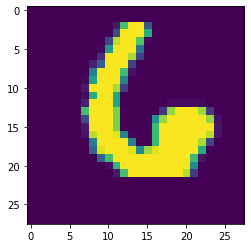

In [56]:
import matplotlib.pyplot as plt

#Vamos ver se a rede previu corretamente
print("O número é: ", y[0])
plt.imshow(X[0].view(28, 28))
print("A rede previu: ", torch.argmax(net(X[0].view(-1, n_h*n_w))[0]))